In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, Dropout, Conv2D, MaxPool2D, 
                                     BatchNormalization, Flatten, GlobalAveragePooling2D, Input)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.applications import EfficientNetB7, MobileNetV2, VGG19, DenseNet121

import pkg_resources
from symspellpy.symspellpy import SymSpell, Verbosity

2024-11-25 14:36:48.165870: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732516608.183734   91670 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732516608.189130   91670 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-25 14:36:48.211096: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/tmp/ipykernel_91670/3465836550.py:20: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa

In [2]:
def directory_to_df(path : str):
    """
    This function to retrieve all images from targeted folder in a file, the
    folder must be divided hirarchally in which each class contains its images individually.
    ________________________________________________________________________________________________
    Arguments-
    
    path: String -> the main folder directory that contains train/test folders
    
    ________________________________________________________________________________________________
    Return-
    
    DataFrame: contains the images path and label corresponding to every image
    """
    df = []
    chars = 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'
    for cls in os.listdir(path):
        cls_path = os.path.join(path,cls)
        cls_name = cls.split('_')[0]
        if not cls_name in chars:
            continue
        for img_path in os.listdir(cls_path):
            direct = os.path.join(cls_path,img_path)
            df.append([direct,cls_name])
    
    df = pd.DataFrame(df, columns=['image','label'])
    print("The number of samples found:",len(df))
    return df.copy()

def read_image(path):
    """
    Read an image from specified directory
    _____________________________________________________________
    Arguments:
    
    path: String -> a directory of the image
    _____________________________________________________________
    Return:
    
    image: numpy.array of the image
    """
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def show_image(img, label=None) -> None:
    """
    This function to display any image
    _________________________________________________________
    Arguements:
    
    img: numpy.array of N-D
    
    label: String -> the title/label added with the image, Default= None
    _________________________________________________________
    Return:
    
    plt.imshow()
    """
    plt.imshow(img, cmap='gray')
    plt.axis(False)
    plt.title(label)
    plt.show()
    
def clbck(model_name):
    # The function is defined to make the callbacks for training the models
    ERLY = EarlyStopping(patience=10, min_delta=0.01, start_from_epoch=10, verbose=1)
    RD = ReduceLROnPlateau(patience=5, min_delta=0.01, factor=0.5)
    CHK = ModelCheckpoint(f'models/{model_name}_model.keras',verbose=1, save_best_only=True)
    return [ERLY,RD,CHK]

In [3]:
# Pre-defined hyperparameters
IMG_SHAPE = (32,32)
IMG_SIZE = (32,32,3)
BATCH_SIZE = 32
opt = Adam(learning_rate=0.0000001, epsilon=1e-6)
loss = 'categorical_crossentropy'
EPOCHS = 10

I0000 00:00:1732516615.928546   91670 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4056 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:08:00.0, compute capability: 7.5


In [4]:
# Set max_dictionary_edit_distance to avoid spelling correction
sym_spell = SymSpell(max_dictionary_edit_distance=0, prefix_length=7)
dictionary_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_dictionary_en_82_765.txt"
)
# term_index is the column of the term and count_index is the
# column of the term frequency
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)

True

## 3) Reading & preparing the dataset

In [5]:
# Reading the dataset in dataframe 
main_path = 'data/raw/character_set3/'
df = directory_to_df(main_path)                   # convert the dataset into df of two columns
df.head()

The number of samples found: 196125


,image,label
0,data/raw/character_set3/5/16817.png,5
1,data/raw/character_set3/5/8285.png,5
2,data/raw/character_set3/5/15737.png,5
3,data/raw/character_set3/5/8249.png,5
4,data/raw/character_set3/5/8213.png,5


In [6]:
df['label'].value_counts()

label
U    4046
E    4046
P    4046
Q    4046
H    4046
     ... 
1     573
8     573
2     573
3     573
9     573
Name: count, Length: 62, dtype: int64

3.1) Splitting the dataframe

In [7]:
# Splitting for training & testing (70,30 respectively)
X, y = df['image'], df['label']
X_train, X_test, y_train, y_test = train_test_split(X,y , test_size=0.30, random_state=41)
training_df = pd.concat((X_train,y_train), axis=1)
testing_df = pd.concat((X_test,y_test), axis=1)

In [8]:
# Splitting for training & validation (75,25 respectively) -> the training set size = 52.5%
X, y = training_df['image'], training_df['label']
X_train, X_valid, y_train, y_valid = train_test_split(X,y , test_size=0.25, random_state=41)
training_df = pd.concat((X_train,y_train), axis=1)
validation_df = pd.concat((X_valid,y_valid), axis=1)

3.2) Creating generators

In [9]:
# Creating generators
gen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    brightness_range=[0.5, 1.5],
    fill_mode='nearest',
    dtype=np.int32
)
gen2 = ImageDataGenerator(dtype=np.int32, fill_mode='nearest')
train_gen = gen.flow_from_dataframe(training_df, x_col='image',y_col='label', batch_size=BATCH_SIZE, 
                                   target_size=IMG_SHAPE)
valid_gen = gen2.flow_from_dataframe(validation_df, x_col='image', y_col='label', batch_size=BATCH_SIZE, 
                                        target_size=IMG_SHAPE, shuffle=False)
test_gen = gen2.flow_from_dataframe(testing_df, x_col='image', y_col='label', batch_size=BATCH_SIZE, 
                                       target_size=IMG_SHAPE, shuffle=False)

Found 102965 validated image filenames belonging to 62 classes.
Found 34322 validated image filenames belonging to 62 classes.
Found 58838 validated image filenames belonging to 62 classes.


In [10]:
# Making a mapping of the classes and the inverse for later processings
mapping = train_gen.class_indices
mapping_inverse = dict(map(lambda x: tuple(reversed(x)), mapping.items()))

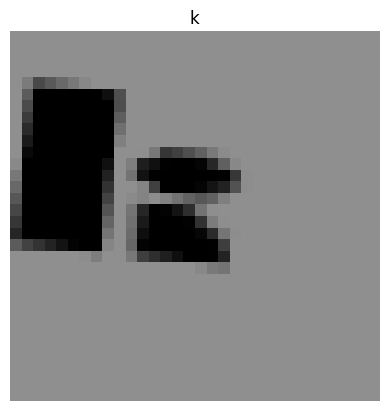

The shape of the image: (32, 32, 3)


In [11]:
# Reading a sample from the dataset
BATCH_NUM = 10
IMG_NUM = 2      # from 0 to 31
show_image(train_gen[BATCH_NUM][0][IMG_NUM],mapping_inverse[train_gen[BATCH_NUM][1][IMG_NUM].argmax()])
print('The shape of the image:',train_gen[BATCH_NUM][0][IMG_NUM].shape)

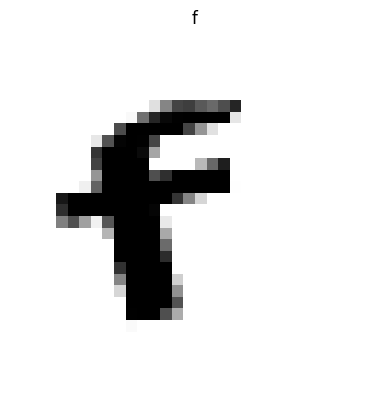

The shape of the image: (32, 32, 3)


In [12]:
# Reading another sample from the dataset
BATCH_NUM = 65
IMG_NUM = 30      # from 0 to 31
show_image(train_gen[BATCH_NUM][0][IMG_NUM],mapping_inverse[train_gen[BATCH_NUM][1][IMG_NUM].argmax()])
print('The shape of the image:',train_gen[BATCH_NUM][0][IMG_NUM].shape)

# 4) Modeling

4.1) Custom CNN

In [55]:
# Custom CNN
CNN_model = Sequential()
CNN_model.add(Input(shape=IMG_SIZE, batch_size=BATCH_SIZE, name='Input'))
CNN_model.add(Conv2D(3, (3,3), strides=1, activation='relu', padding='same'))
CNN_model.add(Conv2D(128, (3,3), activation='relu'))
CNN_model.add(MaxPool2D((3,3)))
CNN_model.add(Conv2D(256, (3,3), activation='relu'))
CNN_model.add(Dropout(0.2))
CNN_model.add(Conv2D(256, (3,3), strides=2, activation='relu', padding='same'))
CNN_model.add(MaxPool2D((2,2)))
CNN_model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
CNN_model.add(Dropout(0.2))
CNN_model.add(Conv2D(1024, (2,2), activation='relu', padding='same'))
CNN_model.add(MaxPool2D(2,2))
CNN_model.add(Flatten())
CNN_model.add(Dense(1024, activation='selu'))
CNN_model.add(Dense(len(mapping), activation='softmax'))

In [56]:
CNN_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (32, 32, 32, 3)        │            84 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (32, 30, 30, 128)      │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (32, 10, 10, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (32, 8, 8, 256)        │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (32, 8, 8, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (32, 4, 4, 256)        │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (32, 2, 2, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (32, 2, 2, 512)        │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (32, 2, 2, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (32, 2, 2, 1024)       │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (32, 1, 1, 1024)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (32, 1024)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (32, 1024)             │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (32, 62)               │        63,550 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,280,402 (20.14 MB)

 Trainable params: 5,280,402 (20.14 MB)

 Non-trainable params: 0 (0.00 B)

In [57]:
# Default parameters of adam will be used for the custom CNN
CNN_model.compile(optimizer=Adam(), loss=loss, metrics=['accuracy'])

In [58]:
# different num. of epochs will be given for better convergence for the Custom CNN
history = CNN_model.fit(train_gen, epochs=30, validation_data=valid_gen, callbacks=clbck("CustomCnn"))

Epoch 1/30


/home/dangazelle/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3217/3218 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.3266 - loss: 2.7613
Epoch 1: val_loss improved from inf to 0.73531, saving model to models/CustomCnn_model.keras
3218/3218 ━━━━━━━━━━━━━━━━━━━━ 106s 32ms/step - accuracy: 0.3268 - loss: 2.7606 - val_accuracy: 0.7919 - val_loss: 0.7353 - learning_rate: 0.0010
Epoch 2/30
3216/3218 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7270 - loss: 0.9664
Epoch 2: val_loss improved from 0.73531 to 0.65572, saving model to models/CustomCnn_model.keras
3218/3218 ━━━━━━━━━━━━━━━━━━━━ 65s 20ms/step - accuracy: 0.7270 - loss: 0.9664 - val_accuracy: 0.8216 - val_loss: 0.6557 - learning_rate: 0.0010
Epoch 3/30
3217/3218 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7584 - loss: 0.8705
Epoch 3: val_loss improved from 0.65572 to 0.58469, saving model to models/CustomCnn_model.keras
3218/3218 ━━━━━━━━━━━━━━━━━━━━ 63s 20ms/step - accuracy: 0.7584 - loss: 0.8705 - val_accuracy: 0.8348 - val_loss: 0.5847 - learning_rate: 0.0010
Epoch 4/30
3216/3218 

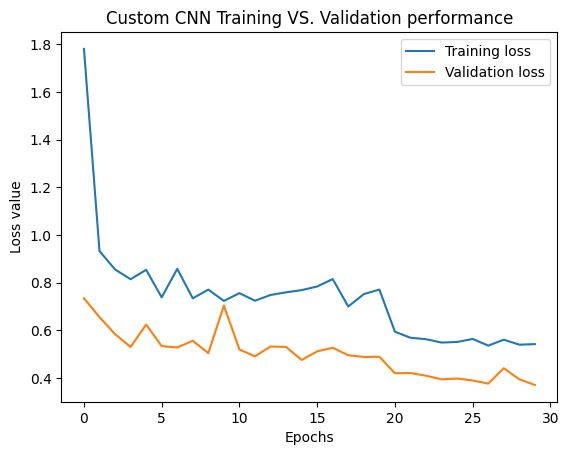

In [59]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss value')
plt.title("Custom CNN Training VS. Validation performance")
plt.show()

In [60]:
# Making a prediction out of the Custom CNN for the testing set for the evaluation
prediction = CNN_model.predict(test_gen)
pred = list(map(lambda x: mapping_inverse[np.argmax(x)], prediction))
y_test = list(map(lambda x: mapping_inverse[x],test_gen.classes))

1839/1839 ━━━━━━━━━━━━━━━━━━━━ 27s 14ms/step


In [61]:
print('\t\tThe Custom CNN Evaluation Performance')
print(classification_report(y_test, pred))

		The Custom CNN Evaluation Performance
              precision    recall  f1-score   support

           0       0.29      0.01      0.02       179
           1       0.97      0.94      0.95       179
           2       1.00      0.96      0.98       180
           3       0.99      0.99      0.99       170
           4       0.96      0.99      0.97       169
           5       0.96      1.00      0.98       166
           6       0.99      0.98      0.99       189
           7       0.98      0.98      0.98       166
           8       0.98      0.99      0.98       163
           9       0.96      0.98      0.97       183
           A       0.90      0.92      0.91      1212
           B       0.91      0.93      0.92      1202
           C       0.92      0.84      0.87      1191
           D       0.52      0.97      0.68      1240
           E       0.94      0.90      0.92      1201
           F       0.90      0.92      0.91      1156
           G       0.92      0.89      0.

# 6) Post-Processing

In [13]:
# Computer Vision - Low level techniques
def load_model():
    model_path = 'models/CustomCnn_model.keras'
    model = tf.keras.models.load_model(model_path)
    return model

def convert_2_gray(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    return gray_image

def binarization(image):
    img, thresh = cv2.threshold(image, 0,255, cv2.THRESH_OTSU|cv2.THRESH_BINARY_INV)
    return img, thresh

def dilate(image, words= False):
    img = image.copy()
    m = 3
    n = m - 2                   # n less than m for Vertical structuring element to dilate chars
    itrs = 4
    if words:
        m = 6
        n = m
        itrs = 3
    rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (n, m))
    dilation = cv2.dilate(img, rect_kernel, iterations = itrs)
    return dilation

def find_rect(image):
    contours, hierarchy = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    rects = []
    
    for cnt in contours:
        x,y,w,h = cv2.boundingRect(cnt)  # Extract the bounding rectangle coordinates of each countour
        rects.append([x,y,w,h])
        
    sorted_rects = list(sorted(rects, key=lambda x: x[0])) # Sorting the rects from Left-to-Right
    return sorted_rects

def extract(image):
    model = load_model()
    chars = []              # a list to store recognized characters
    
    image_cpy = image.copy()
    _, bin_img = binarization(convert_2_gray(image_cpy))
    full_dil_img = dilate(bin_img,words=True)
    words = find_rect(full_dil_img)                       # Recognized words within the image 
    del _, bin_img, full_dil_img                          # for better memory usage
    
    for word in words:
        x,y,w,h = word                                    # coordinates of the word
        img = image_cpy[y:y+h, x:x+w]
        
        _, bin_img = binarization(convert_2_gray(img))
        dil_img = dilate(bin_img)
        char_parts = find_rect(dil_img)                     # Recognized chars withtin the word
        cv2.rectangle(image, (x,y),(x+w,y+h), (0,255,0), 3) # draw a green rectangle around the word
        
        del _, bin_img, dil_img
        
        for char in char_parts:    
            x,y,w,h = char
            ch = img[y:y+h, x:x+w]
            
            empty_img = np.full((32,32,1),255, dtype=np.uint8) # a white image used for resize with filling
            x,y = 3,3                                          # starting indecies
            resized = cv2.resize(ch, (16,22), interpolation=cv2.INTER_CUBIC)
            gray = convert_2_gray(resized)
            empty_img[y:y+22, x:x+16,0] = gray.copy()          # integrate the recognized char into the white image
            gray = cv2.cvtColor(empty_img, cv2.COLOR_GRAY2RGB)
            gray = gray.astype(np.int32)
            
            predicted = mapping_inverse[np.argmax(model.predict(np.array([gray]), verbose=-1))]
            chars.append(predicted)                            # append the character into the list
            
            del ch, resized, gray, empty_img
        chars.append(' ')  # at the end of each iteration (end of word) append a space
        
    del model
    show_image(image)
    return ''.join(chars[:-1])

I0000 00:00:1732516642.464080   98206 service.cc:148] XLA service 0x7fd058003920 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732516642.464151   98206 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2024-11-25 14:37:22.471506: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1732516642.497998   98206 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-11-25 14:37:22.835855: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[1,256,8,8]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,128,10,10]{3,2,1,0}, f32[256,128,3,3]{3,2,1,0}, f32[256]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"acti

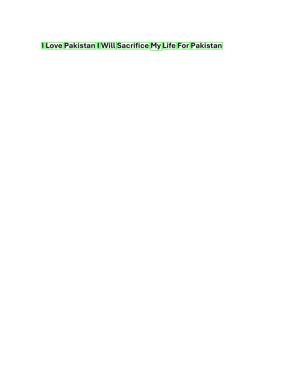

--> L LOVe PakiStaN L WiLL SaCrifiCe My Life FOr PakiStaN


In [14]:
# Testing 1 (Upper case + Lower case)
img = read_image('data/raw/character_set1/Test_5.png')
text = extract(img)
print('-->',text)

In [15]:
input_term = text
result = sym_spell.word_segmentation(input_term)
print(f"{result.corrected_string}, {result.distance_sum}, {result.log_prob_sum}")

L Love Pakistan L Will Sacrifice My Life For Pakistan, 2, -54.014340347173146


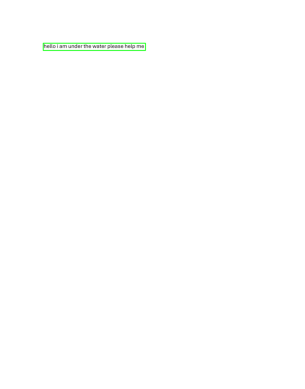

--> heLLOIamundertheWaterpLeaSeheLpme


In [16]:
# Testing 2 (Lower case)
img = read_image('data/raw/character_set1/Test_4.png')
text = extract(img)
print('-->',text)

In [17]:
input_term = text
result = sym_spell.word_segmentation(input_term)
print(f"{result.corrected_string}, {result.distance_sum}, {result.log_prob_sum}")

hello I am under the Water please help me, 8, -29.015747813906575
